In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_Diagnostics as dt
import XSpect.XSpect_PostProcessing

Run 46 imported


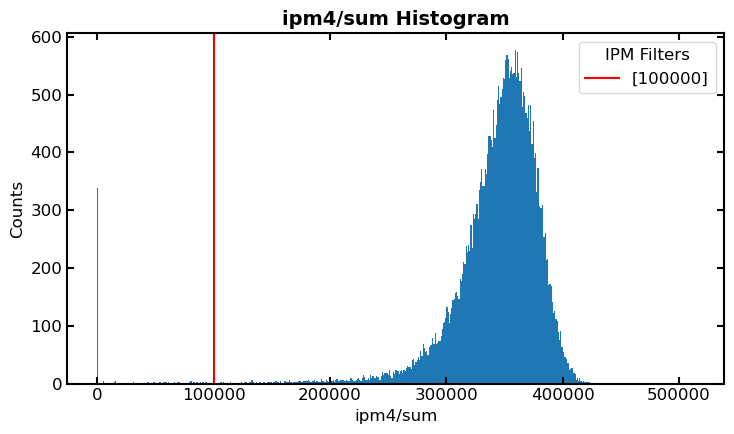

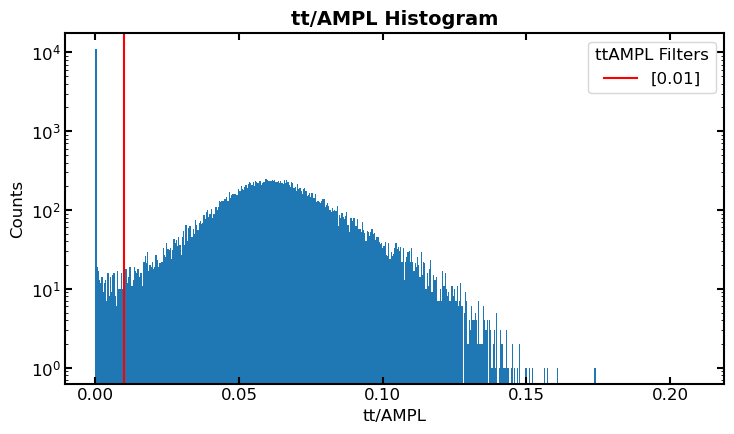

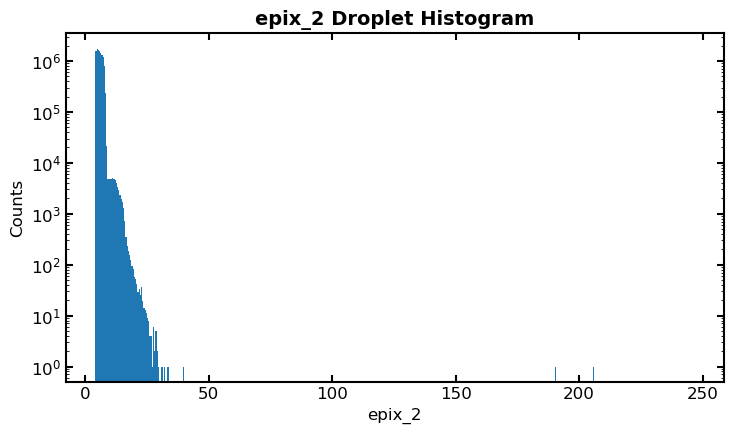

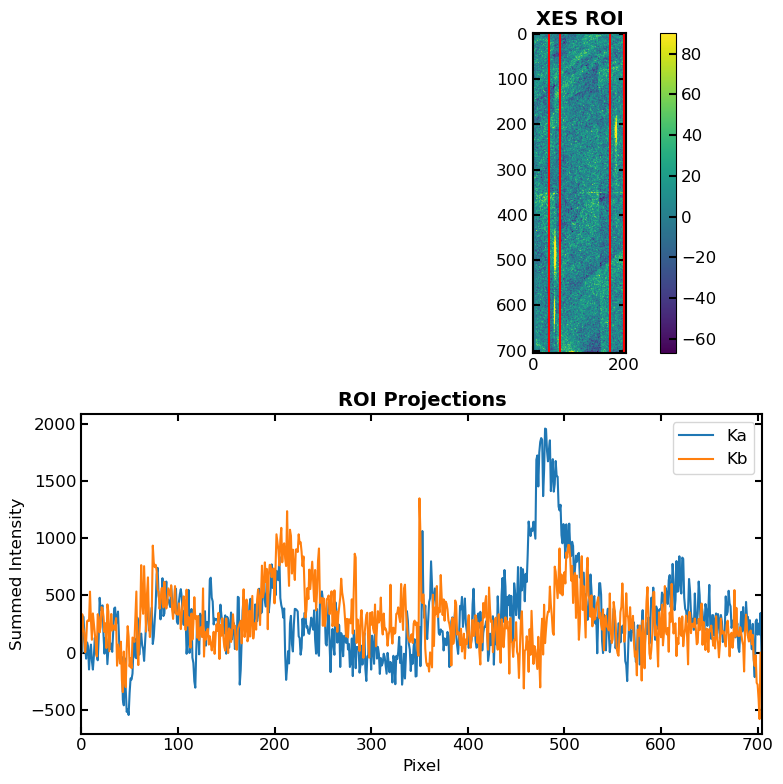

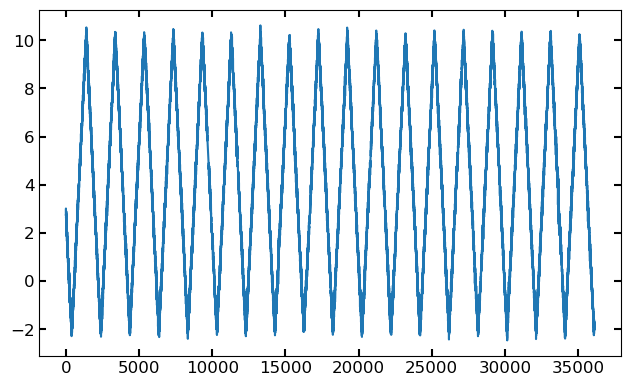

In [2]:
run = 46
exp = 'xcsl1049023'
keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_area'] 
names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']

d = dt.diagnostics(run, exp, keys, names)

ipm_thres = [100000]

d.ipm_histogram(ipm_thres)

tt_thres = [0.01]

d.ttAMPL_histogram(tt_thres)

d.droplet_histogram()

nshots = 1000
ka_roi = [35, 60]
kb_roi = [170, 200]

d.xes_ROI(nshots, ka_limits = ka_roi, kb_limits = kb_roi, angle = 0.5)

delay = d.h5[d.datadict['time_tool_correction']][:] + d.h5[d.datadict['lxt_ttc']][:] + d.h5[d.datadict['encoder']][:]

plt.plot(delay)

In [3]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='xcs',experiment_id='xcsl1049023',lcls_run=23)

xes   = XSpect.XSpect_Controller.XESBatchAnalysisRotation()

keys  = ['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum', 'tt/AMPL'] 
names = ['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl']

xes.key_epix = ['epix_2/ROI_0_area']
xes.friendly_name_epix = ['epix']

xes.set_key_aliases(keys,names)

xes.mintime    = -2
xes.maxtime    = 10
xes.time_step = 0.1 # time bin step size in ps
xes.time_bins = np.arange(xes.mintime, xes.maxtime + xes.time_step, xes.time_step)

# xes.rois       = [[80, 110]]
xes.rois       = [ [85, 100], [220, 235] ]
xes.adu_cutoff = 3.5
xes.angle      = 0.9

xes.add_filter('xray', 'ipm', ipm_thres[0])
xes.add_filter('simultaneous', 'ipm', ipm_thres[0])
xes.add_filter('simultaneous', 'time_tool_ampl', tt_thres[0])

xes.run_parser(['46'])

In [4]:
f = XSpect.XSpect_Analysis.spectroscopy_run(xes_experiment, run, verbose=True, start_index = 0, end_index = None)
analysis=XSpect.XSpect_Analysis.XESAnalysis()

In [5]:
f.get_run_shot_properties()
f.load_run_keys(xes.keys, xes.friendly_names)
f.load_run_key_delayed(xes.key_epix, xes.friendly_name_epix, rois = None)

Obtained shot properties
HDF5 import of keys completed. Time: 0.00 seconds
HDF5 import of keys completed. Time: 17.48 seconds


In [6]:
analysis.time_binning(f, xes.time_bins)

xes.add_filter('xray', 'delays', (min(f.time_bins_centered), max(f.time_bins_centered)))
xes.add_filter('simultaneous', 'delays', (min(f.time_bins_centered), max(f.time_bins_centered)))

Generated timing bins from -2.000000 to 10.000000 in 121 steps.


In [7]:
for fil in xes.filters:
        analysis.filter_shots(f, fil['FilterType'], fil['FilterKey'], fil['FilterThreshold'])

analysis.union_shots(f,'timing_bin_indices',['simultaneous','laser'])
analysis.separate_shots(f,'timing_bin_indices',['xray','laser'])

Mask: xray has been filtered on ipm by minimum threshold: 100000.000
Shots removed: 160
Mask: simultaneous has been filtered on ipm by minimum threshold: 100000.000
Shots removed: 120
Mask: simultaneous has been filtered on time_tool_ampl by minimum threshold: 0.010
Shots removed: 640
Mask: xray has been filtered on delays by minimum threshold: -2.050 and maximum threshold: 10.050
Shots removed: 556
Mask: simultaneous has been filtered on delays by minimum threshold: -2.050 and maximum threshold: 10.050
Shots removed: 550
Shots (24298) combined for detector timing_bin_indices on filters: simultaneous and laser into timing_bin_indices_simultaneous_laser
Shots (10201) separated for detector timing_bin_indices on filters: xray and laser into timing_bin_indices_xray_not_laser


In [8]:
f.timing_bin_indices_simultaneous_laser.shape

(24298,)

Droplet reconstruction completed. Time: 4.69 seconds
Shots (24298) combined for detector epix_ROI_1 on filters: simultaneous and laser into epix_ROI_1_simultaneous_laser
Shots (10201) separated for detector epix_ROI_1 on filters: xray and laser into epix_ROI_1_xray_not_laser
Detector epix_ROI_1_simultaneous_laser_reduced binned in time into key: epix_ROI_1_simultaneous_laser_reduced_time_binned from detector shape: (24298, 702) to reduced shape: (121, 702)
Detector epix_ROI_1_xray_not_laser_reduced binned in time into key: epix_ROI_1_xray_not_laser_reduced_time_binned from detector shape: (10201, 702) to reduced shape: (121, 702)
Shots (24298) combined for detector epix_ROI_2 on filters: simultaneous and laser into epix_ROI_2_simultaneous_laser
Shots (10201) separated for detector epix_ROI_2 on filters: xray and laser into epix_ROI_2_xray_not_laser
Detector epix_ROI_2_simultaneous_laser_reduced binned in time into key: epix_ROI_2_simultaneous_laser_reduced_time_binned from detector sha

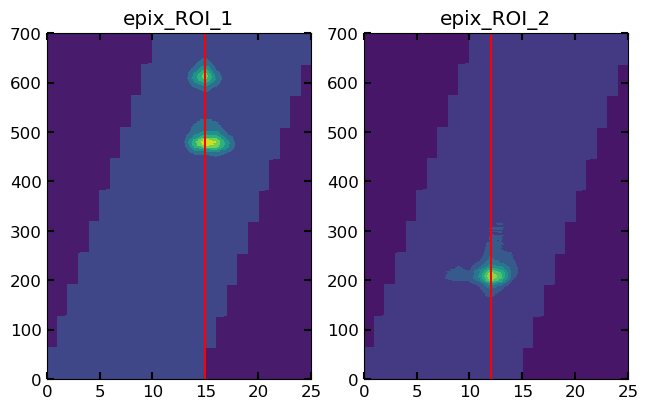

In [11]:
analysis.droplet_reconstruction(f, xes.key_epix, xes.friendly_name_epix, rois = xes.rois, shot_range = [0, None])

roi_list = [attr for attr in dir(f) if 'epix_ROI' in attr]

# print(roi_list)

fig, ax = plt.subplots(nrows = 1, ncols = len(roi_list))

for roi in roi_list:
    if xes.angle != 0:
        
        setattr(f, roi, rotate(getattr(f, roi), angle = xes.angle, axes = [1,2]))

    analysis.union_shots(f, roi, ['simultaneous', 'laser'])
    analysis.separate_shots(f, roi, ['xray', 'laser'])

    label1 = roi + '_simultaneous_laser'
    setattr(f, label1 + '_reduced', np.nansum(getattr(f, label1), axis = -1))
    label2 = roi + '_xray_not_laser'
    setattr(f, label2 + '_reduced', np.nansum(getattr(f, label2), axis = -1))

    label3 = label1 + '_reduced'
    analysis.reduce_detector_temporal(f, label3, 'timing_bin_indices_simultaneous_laser', average = False)
    label4 = label2 + '_reduced'
    analysis.reduce_detector_temporal(f, label4, 'timing_bin_indices_xray_not_laser', average = False)

    # label1 = roi + '_simultaneous_laser'
    # analysis.reduce_detector_temporal(f, label1, 'timing_bin_indices_simultaneous_laser', average = False)
    # label2 = roi + '_xray_not_laser'
    # analysis.reduce_detector_temporal(f, label2, 'timing_bin_indices_xray_not_laser', average = False)

    # label3 = label1 + '_time_binned'
    # # analysis.reduce_detector_spatial(f, label3, combine = False)
    # setattr(f, label3 + '_reduced', np.nansum(getattr(f, label3), axis = -1))
    # label4 = label2 + '_time_binned'
    # setattr(f, label4 + '_reduced', np.nansum(getattr(f, label4), axis = -1))
    # # analysis.reduce_detector_spatial(f, label4, combine = False)

for i, roi in enumerate(roi_list):
    img = np.nansum(getattr(f, roi), axis = 0)
    ax[i].contourf(img)
    peak_indx = np.unravel_index(np.argmax(img, axis = None), img.shape)
    ax[i].axvline(peak_indx[1], color = 'r', linewidth = 1.5)
    ax[i].set_title(roi)

In [14]:
for roi in roi_list:
    label1 = roi + '_simultaneous_laser_reduced_time_binned'
    analysis.normalize_xes(f, label1, pixel_range=[0,None])
    label2 = roi + '_xray_not_laser_reduced_time_binned'
    analysis.normalize_xes(f, label2, pixel_range=[0,None])
    setattr(f, roi + '_difference', getattr(f, label1 + '_normalized') - getattr(f, label2 + '_normalized'))
# spec_difference = spec_laser_on - spec_laser_off

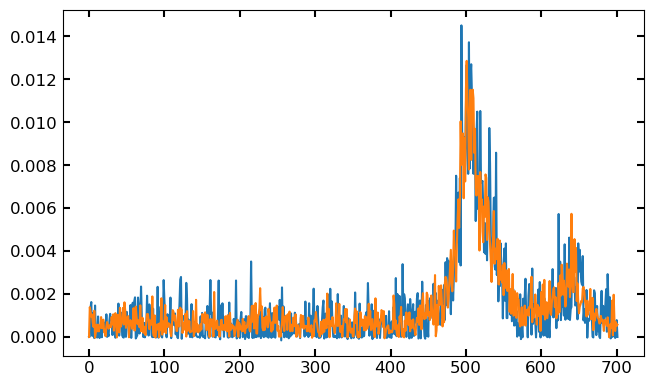

In [21]:
f.time_bins

# time_points = [-0.5, 0, 1, 5]
time_points = [1]

for i, tp in enumerate(time_points):
    indx = np.argmin(np.abs(f.time_bins - tp))
    plt.plot(f.epix_ROI_1_xray_not_laser_reduced_time_binned_normalized[indx,:])
    plt.plot(f.epix_ROI_1_simultaneous_laser_reduced_time_binned_normalized[indx,:])

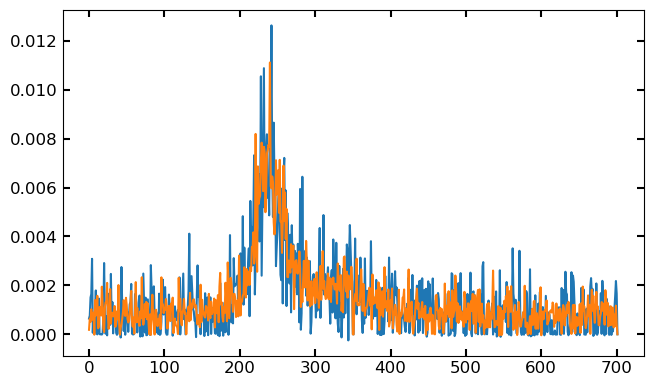

In [22]:
time_points = [1]

for i, tp in enumerate(time_points):
    indx = np.argmin(np.abs(f.time_bins - tp))
    plt.plot(f.epix_ROI_2_xray_not_laser_reduced_time_binned_normalized[indx,:])
    plt.plot(f.epix_ROI_2_simultaneous_laser_reduced_time_binned_normalized[indx,:])

In [15]:
dir(f)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'ccm',
 'close_h5',
 'delays',
 'encoder',
 'end_index',
 'epix',
 'epix_ROI_1',
 'epix_ROI_1_difference',
 'epix_ROI_1_simultaneous_laser',
 'epix_ROI_1_simultaneous_laser_reduced',
 'epix_ROI_1_simultaneous_laser_reduced_bincount',
 'epix_ROI_1_simultaneous_laser_reduced_std',
 'epix_ROI_1_simultaneous_laser_reduced_time_binned',
 'epix_ROI_1_simultaneous_laser_reduced_time_binned_normalized',
 'epix_ROI_1_xray_not_laser',
 'epix_ROI_1_xray_not_laser_reduced',
 'epix_ROI_1_xray_not_laser_reduced_bincount',
 'epix_ROI_1_xray_not_laser_reduced_std',
 'epix_ROI_1_xray_not_laser_reduced_time_binned',
 'epix_ROI_1_xray_not_l

['epix_ROI_1', 'epix_ROI_2']


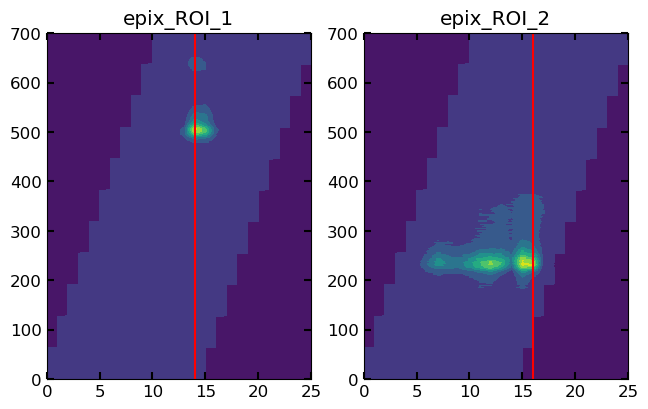

In [11]:
# roi_list = [attr for attr in dir(f) if 'epix_ROI' in attr]

print(roi_list)

fig, ax = plt.subplots(nrows = 1, ncols = len(roi_list))

for i, roi in enumerate(roi_list):
    img = np.nansum(getattr(f, roi), axis = 0)
    ax[i].contourf(img)
    peak_indx = np.unravel_index(np.argmax(img, axis = None), img.shape)
    ax[i].axvline(peak_indx[1], color = 'r', linewidth = 1.5)
    ax[i].set_title(roi)

In [ ]:
f.

In [27]:
time_axis = [-1, 0, 1]
delay_values = [-10, -1.01, 0.5, 2]
bin_indices = np.digitize(delay_values, time_axis)

print(time_axis)
print(delay_values)
print(bin_indices)

[-1, 0, 1]
[-10, -1.01, 0.5, 2]
[0 0 2 3]


In [11]:
print(f.epix_ROI_1.shape)
print(f.epix_ROI_2.shape)
print(f.epix_ROI_1_simultaneous_laser.shape)
print(f.epix_ROI_2_simultaneous_laser.shape)
print(f.epix_ROI_1_xray_not_laser.shape)
print(f.epix_ROI_2_xray_not_laser.shape)

(36821, 702, 26)
(36821, 702, 26)
(25976, 702, 26)
(25976, 702, 26)
(10441, 702, 26)
(10441, 702, 26)


In [14]:
f.status

['New analysis of run 31 located in: /sdf/data/lcls/ds/xcs/xcsl1049023/hdf5/smalldata/xcsl1049023_Run0031.h5',
 'HDF5 import of keys completed. Time: 0.58 seconds',
 'HDF5 import of keys completed. Time: 122.88 seconds',
 'Obtained shot properties']

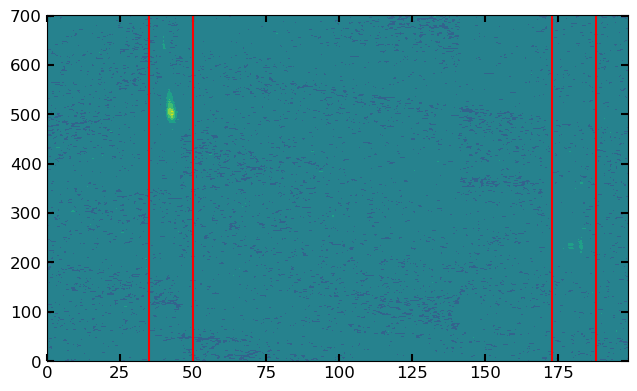

In [8]:
ROI0_ll, ROI0_ul = 35, 50
ROI1_ll, ROI1_ul = 173, 188

plt.contourf(np.nansum(f.epix[0:5000,:,:], axis = 0))
plt.axvline(ROI0_ll, color = 'r')
plt.axvline(ROI0_ul, color = 'r')
plt.axvline(ROI1_ll, color = 'r')
plt.axvline(ROI1_ul, color = 'r')

In [9]:
xes.rois = [ [ROI0_ll, ROI0_ul], [ROI1_ll, ROI1_ul] ]

f.load_run_key_delayed(xes.key_epix, xes.friendly_name_epix, rois = xes.rois, combine = False)

HDF5 import of keys completed. Time: 27.56 seconds


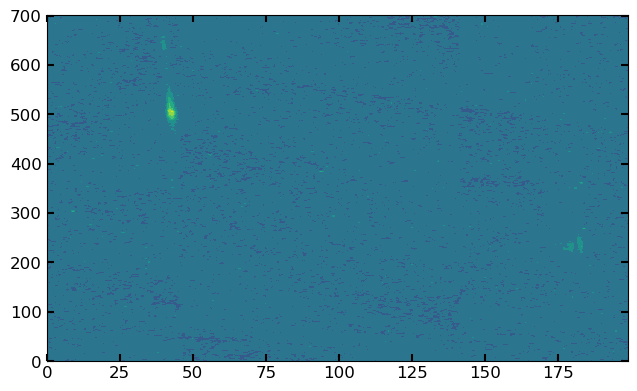

In [10]:
plt.contourf(np.nansum(f.epix[0:3000,:,:], axis = 0))